# Face_Detection_&_Identification.ipynb
By: Shawn Vosburg (260743167)  
Due: November 22th, 2018  
Course: ECSE415, McGill University  

### Data Acquisition

#### You will need a group picture containing at least three people, with their faces clearly visible. This image will be used to evaluate the performance of your implementation. Display the image. Find additional pictures for each individual; the required number of pictures varies with a number of factors, but ten for every person should suffice. These images will be used to build our representation of faces, and should be cropped to be the same size containing only faces. The dimension and use of color is left as a design decision; consider smaller greyscale images if you run into computational issues, or for reducing the dimensionality of the data. Describe how you selected the images with respect to the conditions of the detection/classification methods (5 points). You can download publicly-available images (e.g., celebrities) or acquire your own, but the images must be submitted in .png or .jpeg format.

In [2]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from numpy import linalg as LA

#Setting image_read variables.
categories = {
    0 : "Group",
    1 : "Angela",
    2 : "Kevin",
    3 : "Oscar",
}
folder = "./data/"

imgs = []                # 0-9 = Angela, 10-19 = kevin, 20-29 = Oscar (see imgsLabel)
imgsLabel = np.zeros(30,dtype=int)
imgsLabel[0:10],imgsLabel[10:20],imgsLabel[20:30] = 1,2,3

#Reading images
for idx in range(len(categories)):
    imgType = categories[idx] + "/"
    imgPath = os.listdir(folder+imgType)
    #Read images in subfolder
    if(idx == 0):
        imgFileName = os.listdir(folder+imgType)[0]
        img = cv2.imread(folder+imgType+imgFileName)
        group = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        group = group / 255
        continue
    
    for imgFileName in os.listdir(folder+imgType):
        img = cv2.imread(folder+imgType+imgFileName)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img,(128,256))
        img = img/255
        imgs.append(img)
    
#Displaying images
plt.figure(figsize=(20,20))
plt.subplot(141)
plt.imshow(group,cmap = "gray")
plt.title("Group Image"), plt.xticks([]), plt.yticks([])
plt.subplot(142)
plt.imshow(imgs[0],cmap = "gray")
plt.title("Angela Sample Image"), plt.xticks([]), plt.yticks([])
plt.subplot(143)
plt.imshow(imgs[10],cmap = "gray")
plt.title("Kevin Sample Image"), plt.xticks([]), plt.yticks([])
plt.subplot(144)
plt.imshow(imgs[20],cmap = "gray")
plt.title("Oscar Sample Image"), plt.xticks([]), plt.yticks([])
plt.show()

<Figure size 2000x2000 with 4 Axes>

#### Describe how you selected the images with respect to the conditions of the detection/classification methods

I have selected the images to not all be perfectly front facing. It will hopefully lead to a more robust face detection algorithm. I made sure tho that all main facial features are visibles in each images like the eyes, the mouth and nose. I also included tilted head images as to improve the detector's robustness. The luminosity of the scene are all well lit where the facial features are properly visible. Having a good lit scene will make it easier to detect the eigenvectors of the training data. I also selected images that show different viewpoints of the faces. For example, there are some images where we see more of the left side of Oscar's face and some where we see more of the right side of Oscar's face. 

I did not pick images where the face are occulded because some of the facial features described earlier (eyes, mouth and nose) will be missing  

I also reshaped the images so that the matrix size for PCA would be uniform. 

### Eigenvector Representation

#### Use PCA to find the eigenvector representation of your training data (5 points). Plot the variance explained by every vector in descending order (total variance explained vs. number of principal components) (2 points)

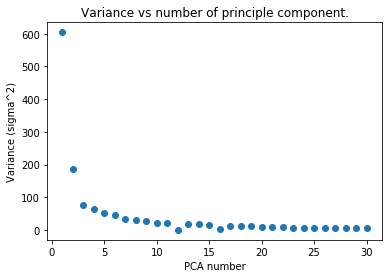

In [3]:
#Create copy of img array to avoid overwriting
D = imgs.copy()
D = np.asarray(D)

#Reshape Img array so that coloumns are the rows are the images and that the columns are the pixel values. 
N,h,w = D.shape
D = D.reshape((N,h*w))

#The Image vector is now a D^T = NxM where M is the number of pixels per image. 
#Subtract mean vector from images. 
rowAverage = np.mean(D,axis=0)
Dnorm = D-rowAverage
rowAverage = rowAverage.reshape((h,w))

#Get Covariance Matrix of size D^T*D, which is NxN.  The eigenvectors are now D^T * v
cov = np.dot(Dnorm,np.transpose(Dnorm)) 
eig, eigVect = LA.eig(cov)
#To get our wanted eigenvectors v, multiply eigenvector of cov with D. 
eigVect = np.transpose(np.dot(np.transpose(Dnorm),eigVect))
eigVect = eigVect.reshape((N,h,w))

#Plotting variance explained by each eigenvector (via associated eigen value)
PCAnum = np.arange(1,N+1)
var = eig/(N-1)
plt.scatter(PCAnum, var)
plt.title("Variance vs number of principle component."), plt.xlabel("PCA number"), plt.ylabel("Variance (sigma^2)")

NUM_OF_USED_PCA = 19


#### Do you need all the vectors to represent the data? Discuss

From the above plot, we clearly do not need all the eigenvectors to represent the data. The first five vectors, which have the greatest variance, is enough to describe the facespace. The other vectors provides little to no destinction between different faces and does not add any benefit computationally to the accuracy of face detection/recongiztion. 

#### How well-clustered is your data? For every sample, find the nearest neighbour (L2 distance), and check whether it is of the same class. What fraction of your data has a neighbour of the same class? Do this both in the original pixel space and the eigenspace, then compare the values; would you expect there to be a significant difference? (10 points).

In [4]:
#Returns label of closest image 
def L2DistImArrLabel(imgArr,labels):
    idx = 0
    matchedLabels = []
    for idxImgA in range(len(imgArr)):
        img = imgArr[idxImgA]
        newArr = imgArr.copy()
        del newArr[idxImgA]
        distArr = LA.norm(LA.norm((newArr - img),axis=2),axis=1) #array of distances between images. 
        print(idxImgA,min(distArr),np.argmin(distArr))
        idx = np.argmin(distArr)
        if(idx >= idxImgA):
            idx += 1
        matchedLabels.append(int(labels[idx]))
    return np.asarray(matchedLabels)

#Returns the minimum distance arr
def getDistfromArr(img, imgArr):
    distArr = LA.norm(LA.norm((imgArr - img),axis=2),axis=1) #array of distances between images.
    return np.asarray(distArr)

#Returns the img array in facespace. Use first three eigenvectors
def toFaceSpace(imgArr):
    inArr = np.asarray(imgArr)
    A,B,C = inArr.shape
    normalized = inArr - rowAverage
    normalized = normalized.reshape((A,B*C))
    #Find angle between the the eigenvectors and the img-mean vector. 
    imgNorm_unit = [normalized[k]/LA.norm(normalized,axis = 1)[k] for k in range(A)]
    eigenVect_unit = [eigVect.reshape((N,h*w))[k] / LA.norm(eigVect.reshape((N,h*w))[k]) for k in range(N)]
    cosTheta = np.inner(imgNorm_unit,eigenVect_unit)
    
    facespace = [rowAverage + sum([cosTheta[i][j] * eigVect[j] for j in range(NUM_OF_USED_PCA)]) for i in range(A)]
    return facespace
    

In [5]:
#Pixel space
print("NOTE: 1 = ANGELA, 2 = KEVIN, 3 = OSCAR")
print("Labels of original images:")
print(imgsLabel,"\n")
print("Labels of closest neighbor in pixel space:")
closestNeighbor = L2DistImArrLabel(imgs,imgsLabel)
print(closestNeighbor)
print("Ratio of images with closest neighbor being of wrong class (pixelspace):", len((closestNeighbor-imgsLabel)[np.where((closestNeighbor-imgsLabel) != 0)]),"/",N)


#Facespace
imgsFaceSpace = toFaceSpace(imgs)
print("\nLabels of closest neighbor in eigenspace:")
closestNeighborFaceSpace= L2DistImArrLabel(imgsFaceSpace,imgsLabel)
print(closestNeighborFaceSpace)
print("Ratio of images with closest neighbor being of wrong class (eigenspace):", len((closestNeighborFaceSpace-imgsLabel)[np.where((closestNeighborFaceSpace-imgsLabel) != 0)]),"/",N)

NOTE: 1 = ANGELA, 2 = KEVIN, 3 = OSCAR
Labels of original images:
[1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3] 

Labels of closest neighbor in pixel space:
0 27.82337934710599 4
1 27.875817054762507 14
2 30.162900285503348 7
3 29.178113225950277 7
4 28.80652506286755 1
5 23.08951006014155 6
6 30.416480336286018 7
7 23.08951006014155 5
8 23.688455295011213 7
9 23.362156197065506 7
10 36.86626182641035 14
11 24.386675823255896 12
12 15.406672810492891 14
13 24.386675823255896 11
14 28.289334994533018 12
15 15.406672810492891 12
16 25.916934710838085 16
17 25.916934710838085 16
18 26.858307061473205 18
19 26.858307061473205 18
20 49.40896941984424 20
21 28.917729755195868 23
22 38.701592626383366 23
23 32.28300009831712 1
24 26.99286106085594 28
25 28.366336704879508 24
26 37.14926364427434 25
27 27.854734949934517 24
28 45.46671604985699 26
29 26.99286106085594 24
[1 2 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 1 3 3 3 3 3 3]
Ratio of images with closest neighbor being of

**Relfection:** The data is not well clustered. It seems from the above experiment that Kevin's images are often identified as Angela, indicating that Kevin's images are most likely spread out in the pixel space with some images being intertwined with the Angela cluster of images. In the original pixel space, there are 8/30 = 0.26 images with a foreign neighbor while in the eigen space, there are 8/30 = 0.26 images with a foreign neighbor.  I expect that the eigen space ratio to be slightly greater than the pixel space ratio since there is a lost of information from doing PCA compression. However, since we are using the eigenvectors that have the largest variance, the relative distance between images should be similar. Therefore, I don't expect there to be a significant difference between the ration in pixel space or eigen space.

### Face Detection & Identification

#### You will now detect the faces in the group image. Use a sliding window to detect whether a section of the image contains a face. Set a threshold on the distance in eigenspace between the window contents and your training data. (15 points). 

0
Match found:  17 27.820475623765553
Match found:  15 27.43360669146689
Match found:  15 23.731431466108646
Match found:  29 26.016790119471235
Match found:  16 25.20600828249045
Match found:  2 23.525663377177388
Match found:  2 27.224296877594444
Match found:  3 17.219146888539694
Match found:  4 24.221878256863793
Match found:  3 26.278744656916658
Match found:  3 22.02688265809054
Match found:  0 27.782742309157253
Match found:  16 20.592523481552043
Match found:  0 17.491092608436983
Match found:  17 26.151780235960683
Match found:  3 27.124877475124404
Match found:  3 12.343719927037998
Match found:  3 16.30022121722545
Match found:  3 24.00616369874046
Match found:  0 21.674857750772574
Match found:  2 27.427648548865214
Match found:  0 13.85655704705908
1
Match found:  14 23.627468793717174
Match found:  17 25.107813240415698
Match found:  3 27.671817369538196
Match found:  3 18.16394282947128
Match found:  0 24.45092534295604
Match found:  0 23.348121818794404
Match found:  1

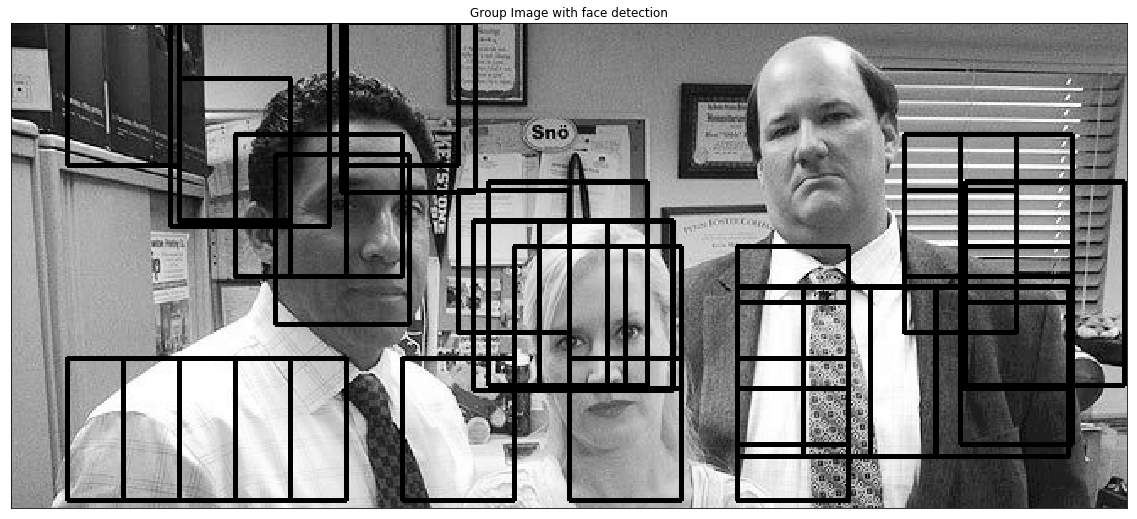

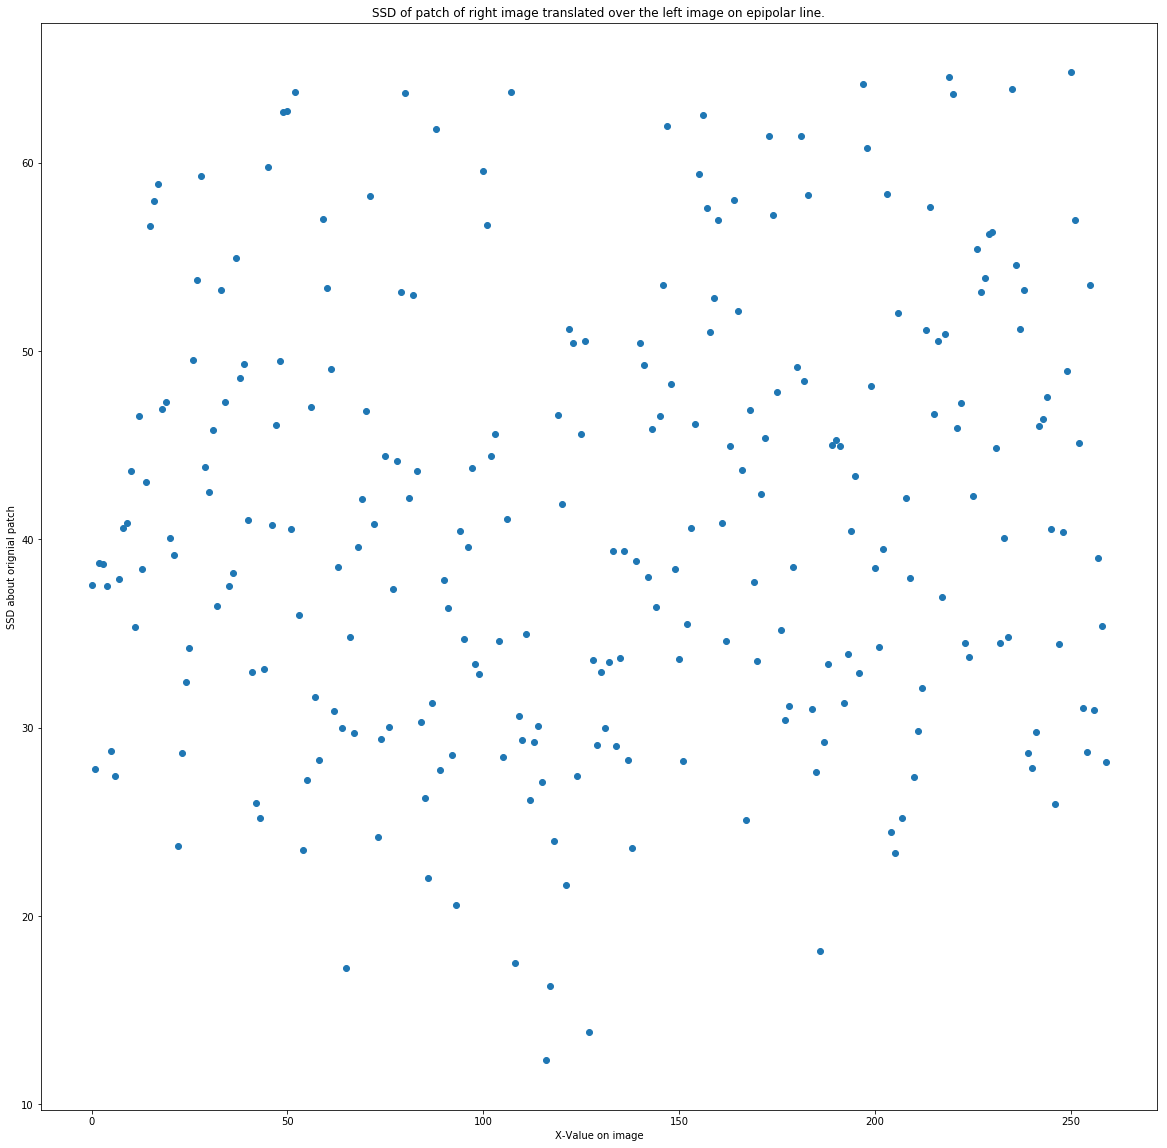

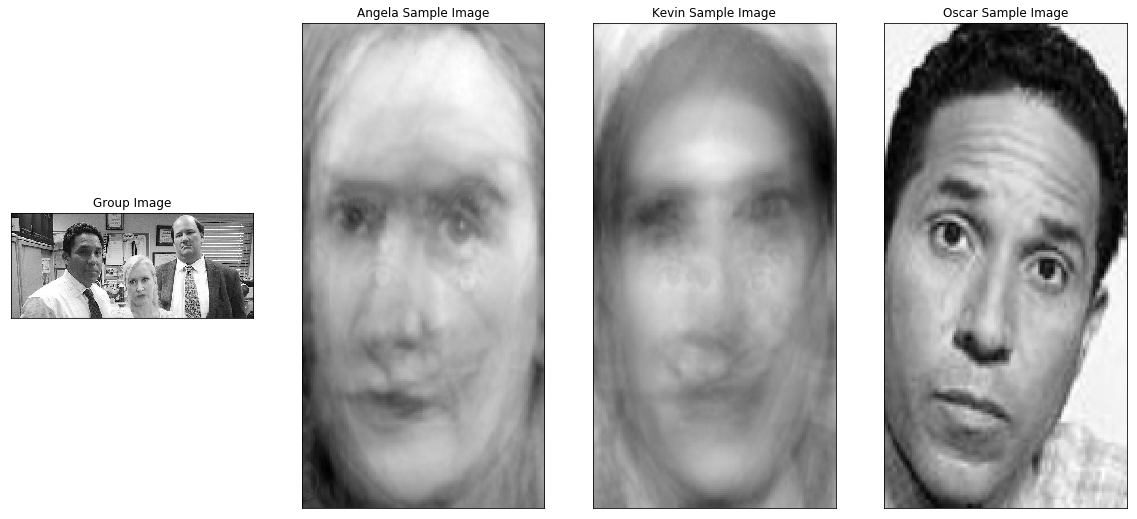

In [7]:
groupDetected = group.copy()

sw = [55,70] #Sliding window size
pyramidSize = 3
scale =1.2
THRESHOLD =28

#Slide window across group image and obtain smallest distance in facespace. 
minDist = []
for z in range(pyramidSize):
    print(z)
    sw = [int(sw[0] * scale),int(sw[1] * scale)] 
    stepSize = int(min(sw[0],sw[1]) // 2)
    for y in range(0, group.shape[0], stepSize):
        for x in range(0, group.shape[1], stepSize):
            #Get Window
            window = group[y:y + sw[1], x:x + sw[0]]
            if window.shape[0] != sw[1] or window.shape[1] != sw[0]:
                continue
            window = cv2.resize(window,(w,h))                    #Resize for scaled out windows. 

            #Get facespace images
            windowFaceSpace = toFaceSpace(window[np.newaxis])
            eigenFacesTemp = imgsFaceSpace.copy()

            #Convert to np array
            windowFaceSpace = np.asarray(windowFaceSpace)
            eigenFacesTemp = np.asarray(eigenFacesTemp)

            #Find SSD of window to training images.
            distances = getDistfromArr(windowFaceSpace,eigenFacesTemp)

            #if min distance is lower than threshold, print a rectangle on image. 
            if(min(distances) <= THRESHOLD):
                cv2.rectangle(groupDetected, (x, y), (x + sw[0], y + sw[1]), (0, 1.0, 0), 2)
                print("Match found: ", np.argmin(distances),min(distances))
                #cv2.imshow("Window", windowFaceSpace[0])
                cv2.waitKey()
            minDist.append(min(distances))
            
            clone = group.copy()
            cv2.rectangle(clone, (x, y), (x + sw[0], y + sw[1]), (0, 1.0, 0), 2)
            cv2.imshow("Window", clone)
            cv2.waitKey(1)
        
cv2.destroyAllWindows()
minDist = np.asarray(minDist)
ind = np.arange(len(minDist))
plt.figure(figsize=(20,20))
plt.imshow(groupDetected,cmap='gray')
plt.title("Group Image with face detection"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(20,20))
plt.scatter(ind,minDist)
plt.title("SSD of patch of right image translated over the left image on epipolar line.")
plt.xlabel("X-Value on image"), plt.ylabel("SSD about orignial patch")
plt.show()

plt.figure(figsize=(20,20))
plt.subplot(141)
plt.imshow(group,cmap = "gray")
plt.title("Group Image"), plt.xticks([]), plt.yticks([])
plt.subplot(142)
plt.imshow(imgsFaceSpace[2],cmap = "gray")
plt.title("Angela Sample Image"), plt.xticks([]), plt.yticks([])
plt.subplot(143)
plt.imshow(rowAverage,cmap = "gray")
plt.title("Kevin Sample Image"), plt.xticks([]), plt.yticks([])
plt.subplot(144)
plt.imshow(imgs[20],cmap = "gray")
plt.title("Oscar Sample Image"), plt.xticks([]), plt.yticks([])
plt.show()